In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import numpy as np

# Entendendo os dados

In [2]:
data = pd.read_csv('SeoulBikeData.csv')

In [3]:
data.head()

,Date,Rented Bike Count,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


O data.info() nos mostra que não há entradas nulas, então não há necessecidade de tratar dados faltantes

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(�C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(�C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

Em baixo irei retirar os dias onde Functioning Day = No, ou seja os dias em que não houve funcionamento do aluguél de bikes

In [5]:
sum(data[data['Functioning Day'] == 'No']['Rented Bike Count'])

0

In [6]:
data = data[data['Functioning Day'] == 'Yes']

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8465 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8465 non-null   object 
 1   Rented Bike Count          8465 non-null   int64  
 2   Hour                       8465 non-null   int64  
 3   Temperature(�C)            8465 non-null   float64
 4   Humidity(%)                8465 non-null   int64  
 5   Wind speed (m/s)           8465 non-null   float64
 6   Visibility (10m)           8465 non-null   int64  
 7   Dew point temperature(�C)  8465 non-null   float64
 8   Solar Radiation (MJ/m2)    8465 non-null   float64
 9   Rainfall(mm)               8465 non-null   float64
 10  Snowfall (cm)              8465 non-null   float64
 11  Seasons                    8465 non-null   object 
 12  Holiday                    8465 non-null   object 
 13  Functioning Day            8465 non-null   objec

In [8]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

In [9]:
data['Month'] = pd.DatetimeIndex(data['Date']).month
data['Year'] = pd.DatetimeIndex(data['Date']).year
data['Day'] = pd.DatetimeIndex(data['Date']).day

# Análise dos dados

Os gráficos abaixo mostram que, os horários de maior procura estão bem definidos, e se mantem independente da estação. Até mesmo durante o inverno, onde há uma enorme redução dos alugueis, as 8 horas e as 18 horas continuam sendo os 2 principais horários de pico

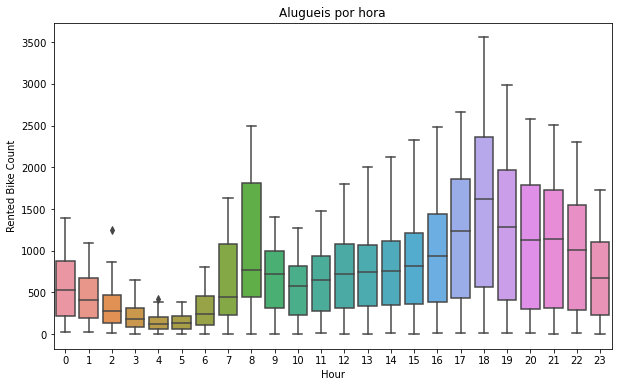

In [10]:
plt.figure(figsize=(10,6))
plt.title('Alugueis por hora')
sns.boxplot(y=data['Rented Bike Count'],x=data['Hour']);

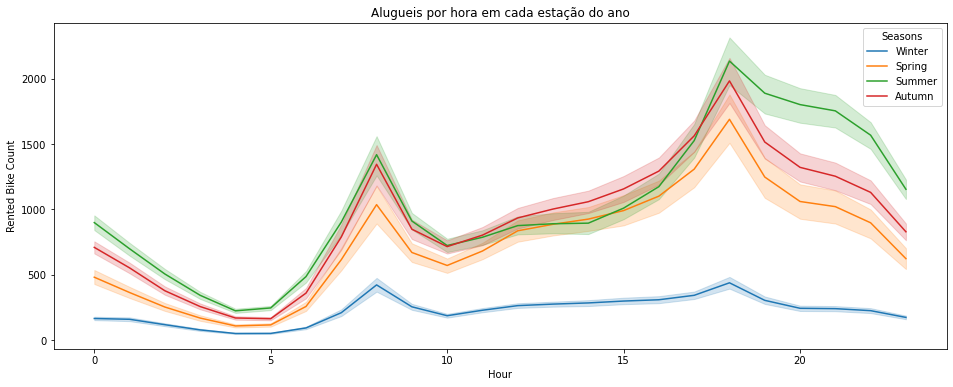

In [11]:
plt.figure(figsize=(16,6))
plt.title('Alugueis por hora em cada estação do ano')
sns.lineplot(y=data['Rented Bike Count'],x=data['Hour'], hue=data['Seasons']);

Os seguintes gráficos confirmam a baixa procura durante o inverno, além de uma procura quase igual durante primavera e outono e a superioridade do verão

Além disso, há uma procura maior durante dias convencionais, e os picos de 8 e 18 horas se mantem, no entanto em feriados não há um pico de procura durante as 8 e sim uma procura quase constante a partir das 10

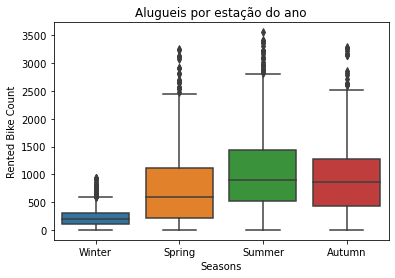

In [12]:
plt.title('Alugueis por estação do ano')
sns.boxplot(y=data['Rented Bike Count'],x=data['Seasons']);

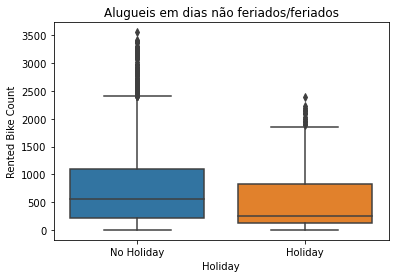

In [13]:
plt.title('Alugueis em dias não feriados/feriados')
sns.boxplot(y=data['Rented Bike Count'],x=data['Holiday']);

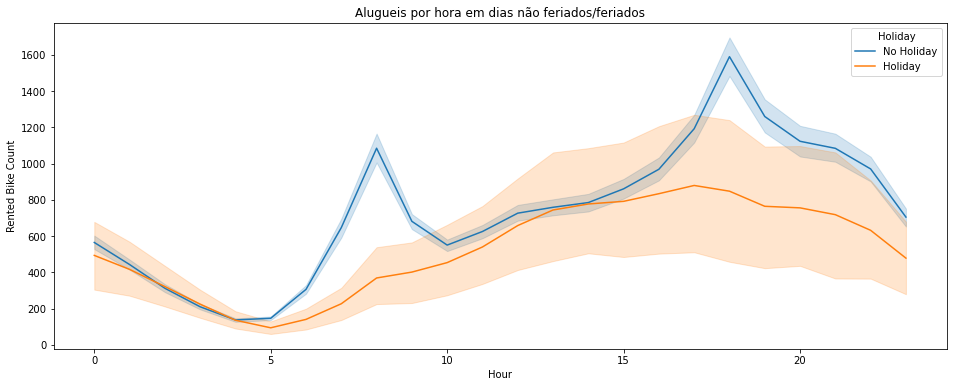

In [14]:
plt.figure(figsize=(16,6))
plt.title('Alugueis por hora em dias não feriados/feriados')
sns.lineplot(y=data['Rented Bike Count'],x=data['Hour'], hue=data['Holiday']);

Aqui vemos que as temperaturas durante a primavera e outono são bem próximas, o inverno é realmente frio e o verão realmente quente. E o gráfico de alugueis por temperatura reforça que, em dias mais quentes, há mais procura. O que não é nenhum absurdo visto que o verão é a estação de maior procura

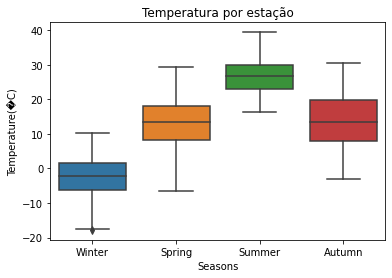

In [15]:
plt.title('Temperatura por estação')
sns.boxplot(y=data['Temperature(�C)'],x=data['Seasons']);

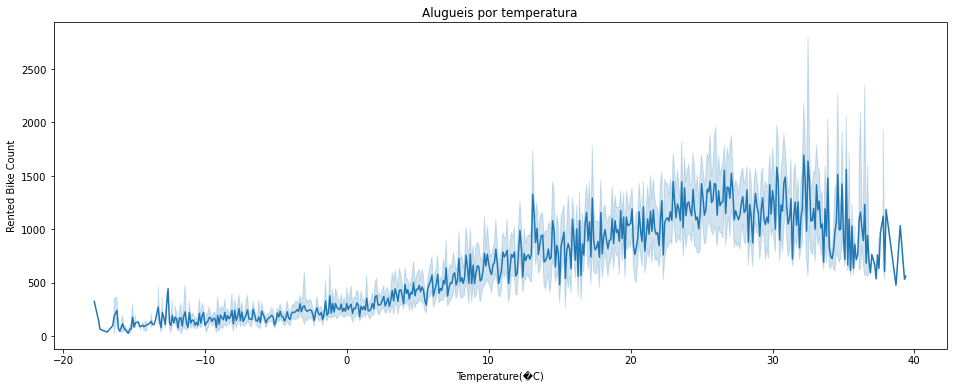

In [16]:
plt.figure(figsize=(16,6))
plt.title('Alugueis por temperatura')
sns.lineplot(y=data['Rented Bike Count'],x=data['Temperature(�C)']);

A seguir analiso a relação do aluguel com chuva, neve e humidade.

Dias com chuva implicam em uma menor procura

Dias com neve implicam em uma menor procura, algo que ja era esperado pois esse fenômeno ocorre durante o inverno

E humidades muito altas, ou muito baixa implicam em uma menor procura

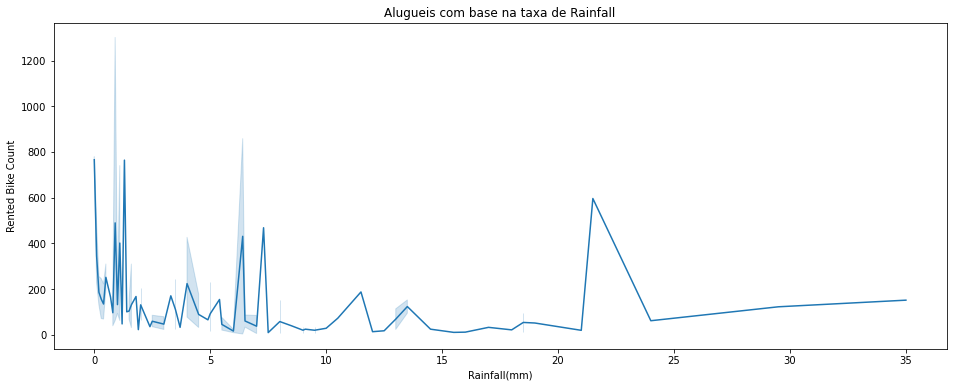

In [17]:
plt.figure(figsize=(16,6))
plt.title('Alugueis com base na taxa de Rainfall')
sns.lineplot(y=data['Rented Bike Count'],x=data['Rainfall(mm)']);

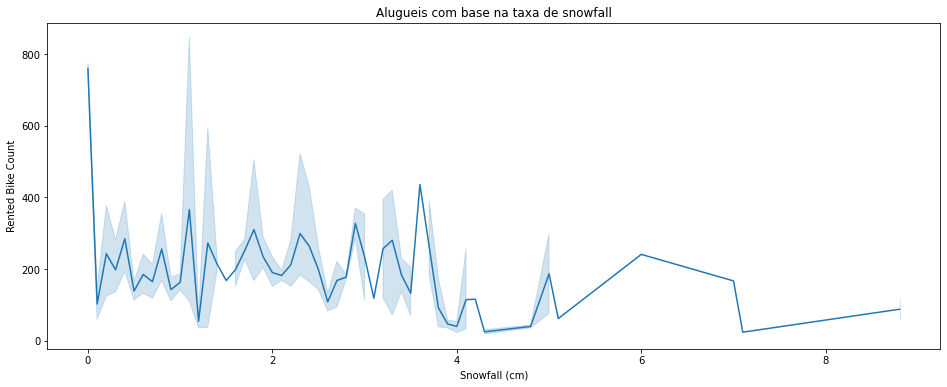

In [18]:
plt.figure(figsize=(16,6))
plt.title('Alugueis com base na taxa de snowfall')
sns.lineplot(y=data['Rented Bike Count'],x=data['Snowfall (cm)']);

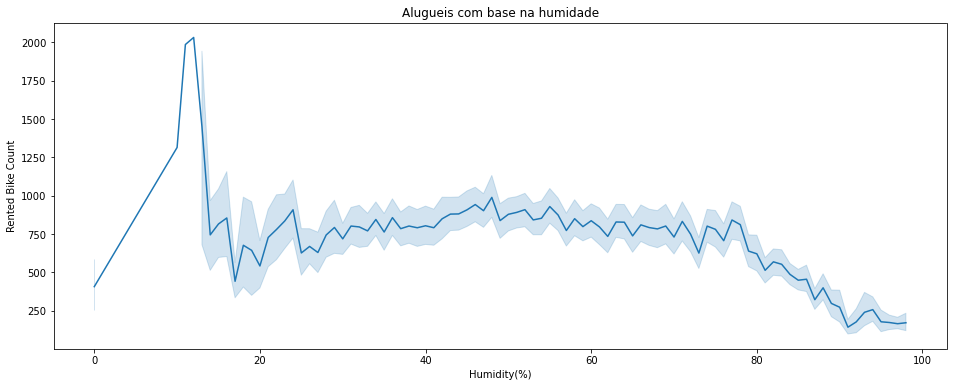

In [19]:
plt.figure(figsize=(16,6))
plt.title('Alugueis com base na humidade')
sns.lineplot(y=data['Rented Bike Count'],x=data['Humidity(%)']);

In [20]:
#Média de alugueis em dias chuvosos
sum(data[data['Rainfall(mm)'] != 0]['Rented Bike Count'])/len(data[data['Rainfall(mm)'] != 0])

167.2577519379845

In [21]:
#Média de alugueis em dias sem chuva
sum(data[data['Rainfall(mm)'] == 0]['Rented Bike Count'])/len(data[data['Rainfall(mm)'] == 0])

765.6320291860611

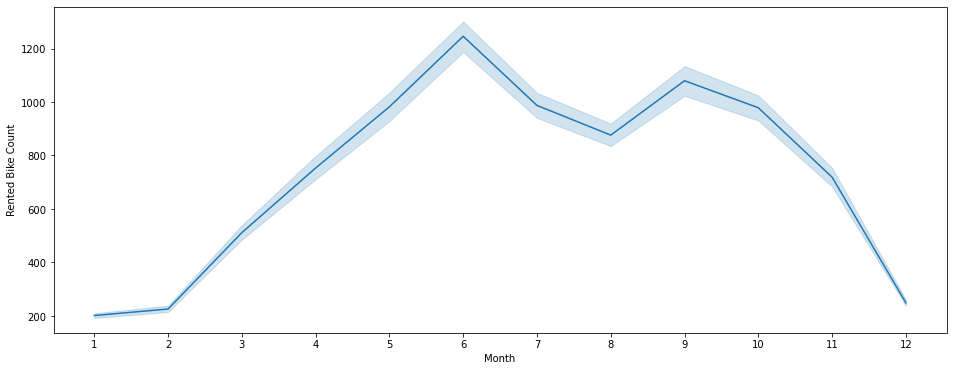

In [22]:
plt.figure(figsize=(16,6))
ax = plt.gca()
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
sns.lineplot(y=data['Rented Bike Count'],x=data['Month'], markers='OO');

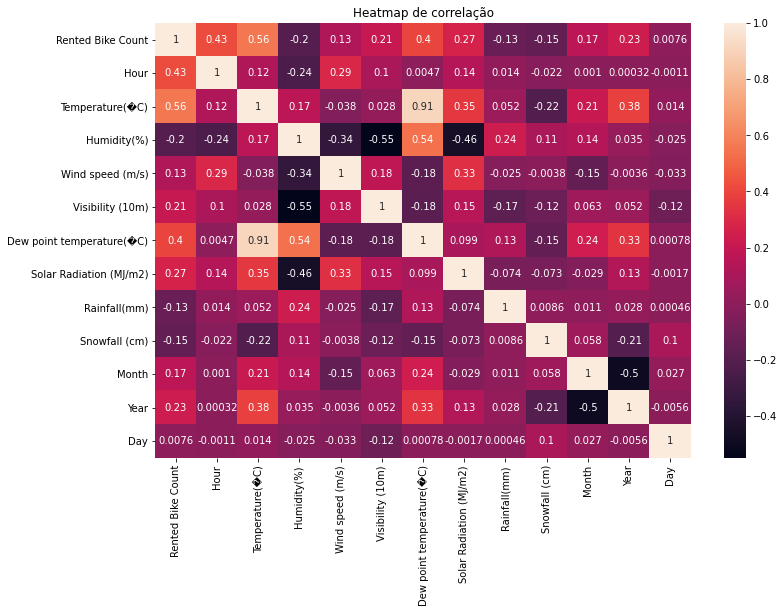

In [23]:
plt.figure(figsize=(12, 8))
plt.title('Heatmap de correlação')
sns.heatmap(data.corr(), annot=True);

Com essa análise podemos inferir que os principais fatores para os alugueis são a temperatura, a hora do dia, a humidade, o indicie de chuva e neve, além dos feriados. Tais coisas são muito bem representadas pelo mês como é possível ver no gráfico acima. Ao que tudo indica o mês 6 é o auge do verão em Seoul, e no mês 11 começa o inverno

Dew point temperature é um reflexo da temperatura, Solar Radiation também

As estações influenciam bastante, pois os dados climáticos são um reflexo disso.

# Preparações para o modelo preditivo 

In [24]:
def RMSLE(y_true:np.ndarray, y_pred:np.ndarray) -> np.float64:
    """
        The Root Mean Squared Log Error (RMSLE) metric 
        
        :param y_true: The ground truth labels given in the dataset
        :param y_pred: Our predictions
        :return: The RMSLE score
    """
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [25]:
data_ml = data.copy()

Crio e transformo os dados de estação e feriados de strings para inteiros, para serem utilizados no modelo

In [26]:
season_dummie = pd.get_dummies(data_ml['Seasons'])

In [27]:
data_ml = pd.concat([data_ml, season_dummie], axis=1)

In [28]:
data_ml['Holiday'] = pd.get_dummies(data_ml['Holiday'], drop_first=True)

In [29]:
data_ml.head()

,Date,Rented Bike Count,Hour,Temperature(�C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(�C),Solar Radiation (MJ/m2),Rainfall(mm),...,Seasons,Holiday,Functioning Day,Month,Year,Day,Autumn,Spring,Summer,Winter
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,...,Winter,1,Yes,12,2017,1,0,0,0,1
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,...,Winter,1,Yes,12,2017,1,0,0,0,1
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,...,Winter,1,Yes,12,2017,1,0,0,0,1
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,...,Winter,1,Yes,12,2017,1,0,0,0,1
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,...,Winter,1,Yes,12,2017,1,0,0,0,1


Agora separo o dataset em 4, cada um representando uma estação e removo os outliars de cada um e posteriormente junto eles novamente

In [30]:
X_ver = data_ml[data_ml['Summer'] == 1]
X_inv = data_ml[data_ml['Winter'] == 1]
X_pri = data_ml[data_ml['Spring'] == 1]
X_out = data_ml[data_ml['Autumn'] == 1]

In [31]:
def out_rem(dataset, column):
    """Remove dados acima do quantil 0.95 e abaixo do quantil 0.05 e retorna o novo dataset"""
    max_tresh = dataset[column].quantile(0.95)
    min_tresh = dataset[column].quantile(0.05)
    df = dataset[(dataset[column] < max_tresh) & (dataset[column] > min_tresh)]
    return df

In [32]:
print(X_ver.shape) #Antes da remoção

(2208, 21)


In [33]:
X_ver = out_rem(X_ver,'Rented Bike Count')
X_inv = out_rem(X_inv,'Rented Bike Count')
X_pri = out_rem(X_pri,'Rented Bike Count')
X_out = out_rem(X_out,'Rented Bike Count')

In [34]:
print(X_ver.shape) #Depois da remoção

(1986, 21)


In [35]:
data_clean = pd.concat([X_ver, X_inv, X_pri, X_out], axis=0) #Junto os 4 datasets limpos

O Boxplot abaixo, quando comparado com o primeiro feito lá em cima confirma que os outliars foram retirados

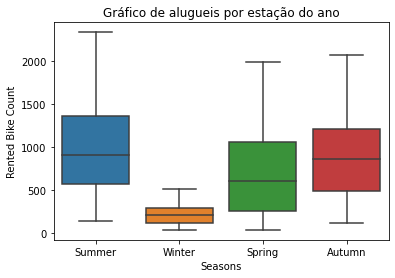

In [36]:
plt.title('Gráfico de alugueis por estação do ano')
sns.boxplot(y=data_clean['Rented Bike Count'],x=data_clean['Seasons']);

Retiro agora os dados que não serão utilizados no modelo, como o dia, ano, o 'Dew point temperature(�C)' que é um reflexo da temperatura, 'Functioning Day', Seasons pois já foi transformada com get_dummies, e 'Winter' pois as colunas Autumn, Spring e Summer já são suficientes para identificação e etc...

In [37]:
data_clean = data_clean.drop(['Visibility (10m)','Wind speed (m/s)','Solar Radiation (MJ/m2)','Functioning Day', 'Date','Winter','Dew point temperature(�C)', 'Seasons', 'Year', 'Day'], axis=1)
data_clean

,Rented Bike Count,Hour,Temperature(�C),Humidity(%),Rainfall(mm),Snowfall (cm),Holiday,Month,Autumn,Spring,Summer
4368,963,0,20.1,63,0.0,0.0,1,6,0,0,1
4369,776,1,19.5,65,0.0,0.0,1,6,0,0,1
4370,554,2,19.0,72,0.0,0.0,1,6,0,0,1
4371,366,3,18.6,72,0.0,0.0,1,6,0,0,1
4372,265,4,18.1,76,0.0,0.0,1,6,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
8755,1003,19,4.2,34,0.0,0.0,1,11,1,0,0
8756,764,20,3.4,37,0.0,0.0,1,11,1,0,0
8757,694,21,2.6,39,0.0,0.0,1,11,1,0,0
8758,712,22,2.1,41,0.0,0.0,1,11,1,0,0


Separando os dados entre treino e teste

In [38]:
X,y = (data_clean.drop(['Rented Bike Count'], axis=1), data_clean['Rented Bike Count'])
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=19, test_size=0.2)

In [39]:
ynorm_train = np.log1p(y_train) #Escrevendo os valores como ln(1+x) para reduzir erros
ynorm_test = np.log1p(y_test)

Escolhi dois modelos potentes de Regressão, RandomForestRegressor e XGBRegressor.

In [40]:
forest_ml = RandomForestRegressor()

In [41]:
forest_ml.fit(X_train,ynorm_train)

RandomForestRegressor()

In [42]:
forest_pred = forest_ml.predict(X_test)

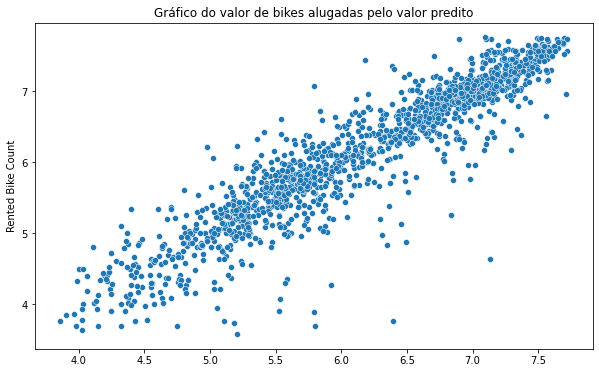

In [43]:
plt.figure(figsize=(10,6))
plt.title('Gráfico do valor de bikes alugadas pelo valor predito')
sns.scatterplot(x=forest_pred,y=ynorm_test); #Normalizado

In [44]:
#Valores normalizados na escala log
print(np.mean(abs(forest_pred-ynorm_test)), ':Erro Absoluto')
print(np.mean(abs(forest_pred-ynorm_test)/ynorm_test),':Erro Relativo')
print(max(ynorm_test),max(forest_pred), ':Maximos normalizado,modelo')
print(min(ynorm_test),min(forest_pred), ':Mínimos normalizado,modelo')
print(RMSLE(ynorm_test,forest_pred), ':RMSLE')

0.23531127334701732 :Erro Absoluto
0.04162925528388024 :Erro Relativo
7.754481547470383 7.7202102445578396 :Maximos normalizado,modelo
3.58351893845611 3.8583145052349868 :Mínimos normalizado,modelo
0.0542578715323702 :RMSLE


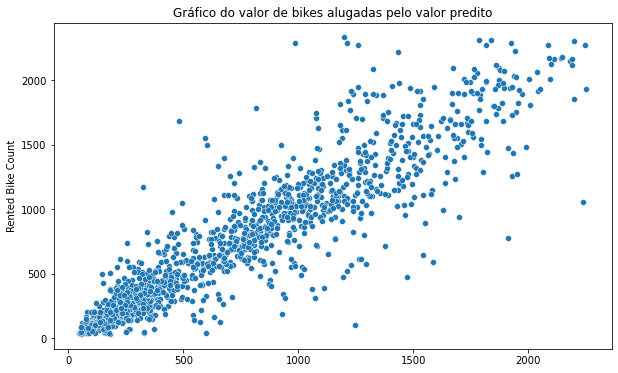

In [45]:
plt.figure(figsize=(10,6))
plt.title('Gráfico do valor de bikes alugadas pelo valor predito')
sns.scatterplot(x=np.e**(forest_pred)-1,y=y_test); #Real

In [46]:
#Valores Reais
print(np.mean(abs(np.e**(forest_pred) -1 -y_test)), ':Erro Absoluto')
print(np.mean(abs(np.e**(forest_pred) -1 -y_test)/y_test),':Erro Relativo')
print(max(y_test),',',max(np.e**(forest_pred)-1), ':Maximos real,modelo')
print(min(y_test),',',min(np.e**(forest_pred)-1), ':Mínimos real,modelo')
print(RMSLE(y_test,np.e**(forest_pred)-1), ':RMSLE')

132.13994233456626 :Erro Absoluto
0.28326209222372156 :Erro Relativo
2331 , 2252.433302856593 :Maximos real,modelo
35 , 46.385416151720754 :Mínimos real,modelo
0.3549619701861152 :RMSLE


In [47]:
xgb_ml = XGBRegressor(n_estimators=1000,learning_rate=0.05, n_jobs=4)

In [48]:
xgb_ml.fit(X_train, ynorm_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_test, ynorm_test)],
             verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
xgb_pred = xgb_ml.predict(X_test)

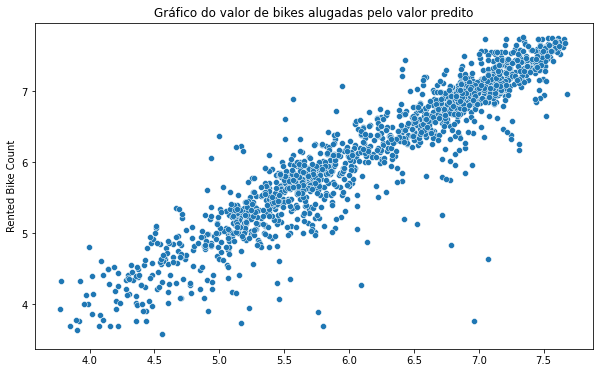

In [50]:
plt.figure(figsize=(10,6))
plt.title('Gráfico do valor de bikes alugadas pelo valor predito')
sns.scatterplot(x=xgb_pred,y=ynorm_test);#Normalizado

In [51]:
#Valores normalizados na escala log
print(np.mean(abs(xgb_pred-ynorm_test)), ':Erro Absoluto')
print(np.mean(abs(xgb_pred-ynorm_test)/ynorm_test),':Erro Relativo')
print(max(ynorm_test),max(xgb_pred), ':Maximos real,modelo')
print(min(ynorm_test),min(xgb_pred), ':Mínimos real,modelo')
print(RMSLE(ynorm_test,xgb_pred), ':RMSLE')

0.22166586770239993 :Erro Absoluto
0.03912328133029473 :Erro Relativo
7.754481547470383 7.682395 :Maximos real,modelo
3.58351893845611 3.7714057 :Mínimos real,modelo
0.05142807181640121 :RMSLE


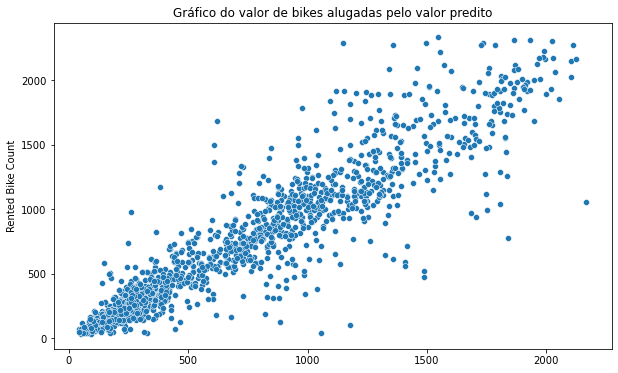

In [52]:
plt.figure(figsize=(10,6))
plt.title('Gráfico do valor de bikes alugadas pelo valor predito')
sns.scatterplot(x=np.e**(xgb_pred)-1,y=y_test);#Real

In [53]:
#Valores reais
print(np.mean(abs(np.e**(xgb_pred) -1 -y_test)), ':Erro Absoluto')
print(np.mean(abs(np.e**(xgb_pred) -1 -y_test)/y_test),':Erro Relativo')
print(max(y_test),',',max(np.e**(xgb_pred)-1), ':Maximos real,modelo')
print(min(y_test),',',min(np.e**(xgb_pred)-1), ':Mínimos real,modelo')
print(RMSLE(y_test,np.e**(xgb_pred)-1), ':RMSLE')

126.6066815732579 :Erro Absoluto
0.2717233832268243 :Erro Relativo
2331 , 2168.8098 :Maximos real,modelo
35 , 42.441082 :Mínimos real,modelo
0.33748976047626844 :RMSLE


# Conclusão #

Dias de chuva, neve e feriados causam um impacto negativo nos alugueis.

O verão é a principal estação para o aluguel, e o inverno é a pior.

O principal horário de procura é as 18 horas, seguido das 8 e por final 17,19, que estão ao redor das 18, execeto no inverno, onde o horário de pico é as 8.

Utilizar o inverno, seguido dos feriados e dias chuvosos para realizar os principais reparos nas bicicletas seria uma boa estratégia para impedir que faltem bicicletas durante os outros períodos, e assim maximizar o lucro

Ambos os modelos tiveram uma boa performance, sendo o XGB o melhor